In [916]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

%matplotlib inline

In [917]:
# !pip install gensim==3.0.0

In [918]:
# !pip install scipy==1.0.0

In [919]:
df = pd.read_csv("data/processedtest.csv")
df.head()
df.columns

Index(['Unnamed: 0', 'cid', 'smiles', 'action'], dtype='object')

In [920]:
import gensim
gensim.__version__

'3.0.0'

In [921]:
# remove null values
df = df[~df["action"].isnull()]

In [922]:
df['action'].value_counts()

AGONIST            108
ANTAGONIST          57
FULL AGONIST        19
PARTIAL AGONIST     14
POSITIVE             4
BINDER               2
NEUTRAL              2
BIASED AGONIST       2
OTHER/UNKNOWN        1
LIGAND               1
Name: action, dtype: int64

In [923]:
def parse(x):
    x = str(x)
    if x.startswith("FULL "):
        return "AGONIST"
    else:
        return x
        
df["action_gen"] = df["action"].apply(parse)
df["action_gen"].value_counts()

AGONIST            127
ANTAGONIST          57
PARTIAL AGONIST     14
POSITIVE             4
BINDER               2
NEUTRAL              2
BIASED AGONIST       2
OTHER/UNKNOWN        1
LIGAND               1
Name: action_gen, dtype: int64

In [924]:
condition = (df.action_gen != "AGONIST") & (df.action_gen != "ANTAGONIST") & (df.action_gen != "PARTIAL AGONIST")
df["action_gen"] = np.where(condition, "OTHER", df.action_gen)

In [925]:
df["action_gen"].value_counts()

AGONIST            127
ANTAGONIST          57
PARTIAL AGONIST     14
OTHER               12
Name: action_gen, dtype: int64

In [926]:
df = df.drop_duplicates(subset=['cid'])
df = df[['cid', 'smiles', 'action', 'action_gen']]
df.set_index('cid', inplace=True)
df.to_csv('data/processed/basic_data.csv')

In [927]:
df.shape

(171, 3)

In [928]:
print(">>> create mol from smiles ... ")
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 

print(">>> create sentence from mol ... ")
df['sentence'] = df.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], radius=1)), axis=1)

print(">>> load the word2vec model ... ")
from gensim.models import word2vec
w2v_model = word2vec.Word2Vec.load('model\\model_300dim.pkl')
# w2v_model = word2vec.Word2Vec.load('model_300dim.pkl')

print(">>> create embedding from sentence ... ")
df['embedding'] = [DfVec(x) for x in sentences2vec(df['sentence'], w2v_model)]

print(">>> data columns = ", df.columns, "\n")

df_mol2vec = np.array([x.vec for x in df['embedding']])
df_mol2vec = pd.DataFrame(df_mol2vec)


>>> create mol from smiles ... 
>>> create sentence from mol ... 
>>> load the word2vec model ... 
>>> create embedding from sentence ... 
>>> data columns =  Index(['smiles', 'action', 'action_gen', 'mol', 'sentence', 'embedding'], dtype='object') 



In [929]:
df_mol2vec

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,6.280141,-0.328470,2.414576,-1.690867,-7.861639,-6.867691,-9.626471,-13.199176,-1.294791,-11.148396,...,19.299658,2.169511,-0.793115,-16.764660,13.043880,-18.739483,3.756747,15.374719,-14.515256,-6.286633
1,1.776356,3.756445,-6.181037,-5.822800,-5.826627,-4.405025,-8.603537,-10.111814,-4.385093,-8.642610,...,16.824162,5.012199,-1.432787,-14.343889,10.836793,-18.628334,1.475181,15.598952,-10.674813,-5.693790
2,6.314234,5.259421,-0.680459,-7.090142,-2.442776,-9.001303,-11.153745,-11.118653,-4.218091,-11.227092,...,20.611570,7.556344,-1.368805,-18.631535,10.332385,-18.168184,-0.347461,11.707021,-13.346869,-9.483927
3,3.372167,-0.755933,-3.060266,-4.772605,-6.081095,-6.983521,-10.408932,-9.785253,-7.122725,-12.498787,...,19.356724,8.006906,-1.125456,-17.910374,7.266664,-21.190121,2.686775,13.276052,-11.772227,-3.436572
4,-1.496679,6.152759,0.588301,-6.650611,-5.761706,-5.832739,-4.404896,-4.544698,-2.249762,-4.385048,...,13.872375,1.219543,-6.606980,-8.758172,7.176021,-14.006166,5.154285,11.168540,-6.243005,-2.394396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,3.702456,-1.441905,-3.830351,-4.911148,-9.687961,-5.936050,-11.954692,-8.482609,-2.526412,-11.928185,...,18.830000,3.986431,-5.243053,-14.841425,6.901628,-23.908350,2.742482,15.500882,-11.651638,-2.351627
167,3.461288,-1.513749,-3.431657,-5.302059,-9.319710,-5.905469,-11.412456,-8.100624,-2.178119,-11.863521,...,18.322538,4.380358,-5.922580,-15.014755,6.630800,-23.506742,2.896177,15.085280,-11.980536,-2.415028
168,-0.374055,3.579891,-6.851539,-12.594655,-7.360147,-5.953069,-13.223902,-11.967194,1.312468,-4.554150,...,26.341173,-1.922469,-4.906705,-22.792141,18.464617,-28.491587,12.383924,20.470411,-24.913034,-1.457546
169,3.816453,0.769446,-2.545771,-5.988578,-10.221293,-4.583409,-9.938968,-15.230546,-2.148406,-19.600471,...,23.059633,7.594724,-7.413008,-14.945212,17.409239,-31.190739,4.204212,17.317575,-16.193220,-1.041622


In [930]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import rand_score

In [931]:
# add indexes to dictionary
df.reset_index(inplace=True)
# encoding
# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()
# df['encoded_label'] = labelencoder.fit_transform(df['action_gen'])
df

,cid,smiles,action,action_gen,mol,sentence,embedding
0,2159,CCN1CCCC1CNC(=O)C2=CC(=C(C=C2OC)N)S(=O)(=O)CC,AGONIST,AGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 225184566...","(100,) dimensional vector"
1,2160,CN(C)CCC=C1C2=CC=CC=C2CCC3=CC=CC=C31,BINDER,OTHER,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3818546315, 848128881, 3121777292...","(100,) dimensional vector"
2,2562,CCN(CC)CCOCCOC(=O)C1(CCCC1)C2=CC=CC=C2,ANTAGONIST,ANTAGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 592593828...","(100,) dimensional vector"
3,3345,CCC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3,AGONIST,AGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 206478835...","(100,) dimensional vector"
4,3821,CNC1(CCCCC1=O)C2=CC=CC=C2Cl,BINDER,OTHER,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3824063894, 847961216, 1733418522...","(100,) dimensional vector"
...,...,...,...,...,...,...,...
166,132990963,C1CCC(CC1)N2CCN(CC2)C(CC3=CC=CC=C3)C4=CC=C(C=C4)F,AGONIST,AGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2968968094, 2142032900, 2968968094, 214203290...","(100,) dimensional vector"
167,132990975,C1CCC(CC1)N2CCN(CC2)C(CC3=CC=CC=C3)C4=CC=CC=C4F,AGONIST,AGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2968968094, 2142032900, 2968968094, 214203290...","(100,) dimensional vector"
168,134156377,CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)OC)O[C...,AGONIST,AGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3657471097, 2092489639, 201425559...","(100,) dimensional vector"
169,137434175,CCC1=CC2=C(C(=C(N=C2C(=C1)F)N3CCC(CC3)NC4CCOCC...,ANTAGONIST,ANTAGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 618671879...","(100,) dimensional vector"


In [932]:
# scaler = StandardScaler()
# df_mol2vec = scaler.fit_transform(df_mol2vec)

# scaler = MinMaxScaler()
# df_mol2vec = scaler.fit_transform(df_mol2vec)


0.9999999403461572


c:\Users\Public\anaconda3\envs\m2vec\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


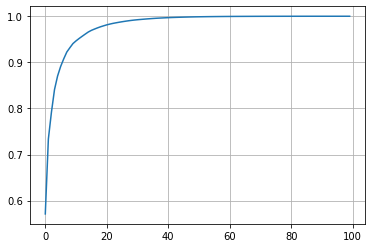

In [933]:
scaler = StandardScaler()
df_mol2vec_scaled = scaler.fit_transform(df_mol2vec)

pca = PCA().fit(df_mol2vec_scaled)
pc = pca.transform(df_mol2vec_scaled)

var = pca.explained_variance_ratio_[:10]
cum_sum = np.cumsum(pca.explained_variance_ratio_)
labels = ['PC'+ str(i) for i in range(1,11)]

print(sum(pca.explained_variance_ratio_))
# sns.barplot(labels, var)
sns.lineplot([x for x in range(len(cum_sum))], cum_sum)
plt.grid()
plt.show()

## Cluster from PC1 to PC5

In [934]:
pca_num_components = 5


reduced_data = PCA(n_components=pca_num_components).fit_transform(df_mol2vec_scaled)
results = pd.DataFrame(reduced_data,columns=['pc' + str(x) for x in range(1, 6)])

# sns.scatterplot(x="pca1", y="pca2", hue=df['action_gen'], data=results)
# plt.title('Clusters on PCA with actual values')
# plt.show()


clustering_kmeans = KMeans(n_clusters=4)
results['clusters'] = clustering_kmeans.fit_predict(results)
results['clusters']

0      2
1      2
2      2
3      2
4      2
      ..
166    2
167    2
168    0
169    0
170    0
Name: clusters, Length: 171, dtype: int32

In [935]:
print(results['clusters'].value_counts())
cluster_dict = dict(results['clusters'].value_counts())
cluster_dict = dict(sorted(cluster_dict.items(), key=lambda item: item[1], reverse=True)).keys()
cluster_dict = list(cluster_dict)

results['action_gen'] = df['action_gen']
results['action_gen_cluster'] = results['clusters'].map({cluster_dict[0]: 'AGONIST', cluster_dict[1]: 'ANTAGONIST', cluster_dict[2]: 'ANTAGONIST', cluster_dict[3]: 'OTHER'})

print('pairing_score: ', rand_score(results.action_gen, results.action_gen_cluster))
results[results.action_gen == results.action_gen_cluster].shape[0] / results.shape[0]
print('Accuracy', results[results.action_gen == results.action_gen_cluster].shape[0] / results.shape[0])

2    89
0    75
3     4
1     3
Name: clusters, dtype: int64
pairing_score:  0.5628482972136223
Accuracy 0.6140350877192983


## PCA before clusters (PC1 & PC2)

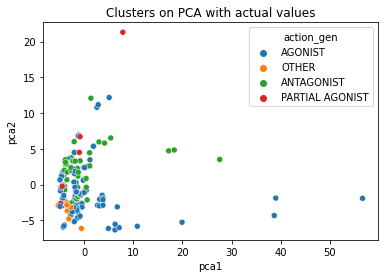

In [936]:
pca_num_components = 2


reduced_data = PCA(n_components=pca_num_components).fit_transform(df_mol2vec_scaled)
results2 = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=df['action_gen'], data=results2)
plt.title('Clusters on PCA with actual values')
plt.show()


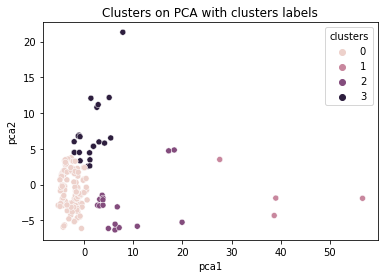

In [937]:
clustering_kmeans = KMeans(n_clusters=4)
results2['clusters'] = clustering_kmeans.fit_predict(results2)
results2['clusters']

sns.scatterplot(x="pca1", y="pca2", hue=results2['clusters'], data=results2)
plt.title('Clusters on PCA with clusters labels')
plt.show()

## Cluster before PCA

In [938]:
clustering_kmeans = KMeans(n_clusters=4)
df_mol2vec['clusters'] = clustering_kmeans.fit_predict(df_mol2vec)
df_mol2vec['clusters']

0      3
1      3
2      3
3      3
4      3
      ..
166    3
167    3
168    3
169    3
170    0
Name: clusters, Length: 171, dtype: int32

c:\Users\Public\anaconda3\envs\m2vec\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


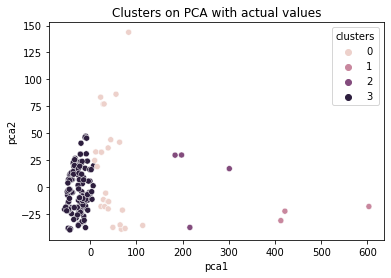

In [939]:
pca_num_components = 2

reduced_data = PCA(n_components=pca_num_components).fit_transform(df_mol2vec)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=df_mol2vec['clusters'], data=results)
plt.title('Clusters on PCA with actual values')
plt.show()

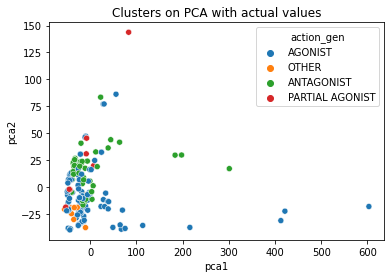

In [940]:
sns.scatterplot(x="pca1", y="pca2", hue=df['action_gen'], data=results)
plt.title('Clusters on PCA with actual values')
plt.show()

## Results comparison

In [941]:
# sort keys based on number of values in each clusters
print(results2['clusters'].value_counts())
cluster_dict = dict(results2['clusters'].value_counts())
cluster_dict = dict(sorted(cluster_dict.items(), key=lambda item: item[1], reverse=True)).keys()
cluster_dict = list(cluster_dict)

results2['action_gen'] = df['action_gen']
results2['action_gen_cluster'] = results2['clusters'].map({cluster_dict[0]: 'AGONIST', cluster_dict[1]: 'ANTAGONIST', cluster_dict[2]: 'ANTAGONIST', cluster_dict[3]: 'OTHER'})

print('pairing_score: ', rand_score(results2.action_gen, results2.action_gen_cluster))
results2[results2.action_gen == results2.action_gen_cluster].shape[0] / results2.shape[0]
print('Accuracy', results2[results2.action_gen == results2.action_gen_cluster].shape[0] / results2.shape[0])

0    127
3     23
2     17
1      4
Name: clusters, dtype: int64
pairing_score:  0.496594427244582
Accuracy 0.5321637426900585


In [942]:
# sort keys based on number of values in each clusters
print(df_mol2vec['clusters'].value_counts())
cluster_dict = dict(df_mol2vec['clusters'].value_counts())
cluster_dict = dict(sorted(cluster_dict.items(), key=lambda item: item[1], reverse=True)).keys()
cluster_dict = list(cluster_dict)

df_mol2vec['action_gen'] = df['action_gen']
df_mol2vec['action_gen_cluster'] = df_mol2vec['clusters'].map({cluster_dict[0]: 'AGONIST', cluster_dict[1]: 'ANTAGONIST', cluster_dict[2]: 'PARTIAL AGONIST', cluster_dict[3]: 'OTHER'})

print('pairing_score: ', rand_score(df_mol2vec.action_gen, df_mol2vec.action_gen_cluster))
df_mol2vec[df_mol2vec.action_gen == df_mol2vec.action_gen_cluster].shape[0] / df_mol2vec.shape[0]
print('Accuracy', df_mol2vec[df_mol2vec.action_gen == df_mol2vec.action_gen_cluster].shape[0] / df_mol2vec.shape[0])

3    137
0     27
2      4
1      3
Name: clusters, dtype: int64
pairing_score:  0.47327141382868937
Accuracy 0.5321637426900585


In [943]:
df['action_gen'].value_counts()

AGONIST            108
ANTAGONIST          43
PARTIAL AGONIST     11
OTHER                9
Name: action_gen, dtype: int64